In [1]:
import os
os.chdir("/kaggle/input/ptb-xl-neimark") # Перейдем в Input (только для чтения!)
!ls # Посмотреть содержимое

X_train_ptbxl_superdiag.npy  y_train_ptbxl_superdiag.npy
X_val_ptbxl_superdiag.npy    y_val_ptbxl_superdiag.npy


In [2]:
os.chdir("/kaggle/working/") # Перейдем в Output
!ls

__notebook_source__.ipynb


In [3]:
!pip install --upgrade tslearn wfdb sktime tsaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 7.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 50.3 MB/s eta 0:00:0000:0100:01


In [4]:
# data
# system
import os
import time
import math
import ast
import random
# wfdb
import wfdb
# tqdm
from tqdm import tqdm
# numpy and pandas
import pandas as pd
import numpy as np
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# tslearn
from tslearn.utils import to_time_series, to_time_series_dataset, save_time_series_txt, load_time_series_txt
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler, TimeSeriesScalerMeanVariance
# sktime
from sktime.transformations.panel.compose import ColumnConcatenator
# tsaug
from tsaug import AddNoise

# visualization
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# sktime
from sktime.utils.plotting import plot_series

# metrics
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, pairwise_distances, classification_report
# sktime
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanSquaredError, mean_absolute_percentage_error

# model
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
# sktime
from sktime.classification.interval_based import TimeSeriesForestClassifier, DrCIF
from sktime.classification.kernel_based import RocketClassifier
# tslearn
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras import layers

np.random.seed(42)

In [5]:
# Transformations

def fourier_transform(X, coeffs=80):
    X_ft = np.empty_like(X)
    for i in range(len(X)):
        sample_fft = np.fft.rfft(X[i].T)
        indices = np.array([[j < coeffs for j, _ in enumerate(sample_fft[k])] for k in range(len(sample_fft))])
        X_ft[i] = np.fft.irfft(indices * sample_fft).T
    
    return X_ft

def rolling_average(X, n=4): # n - размер окна
    shape = list(X.shape)
    shape[1] -= n-1 
    X_ra = np.empty(shape)
    for i in range(len(X)):
        sample = X[i].T
        X_ra[i] = np.array([np.convolve(signal, np.ones(n), 'valid') / n for signal in sample]).T
    return X_ra

# Metrics and confusion matrix

def draw_confusion_matrix(y, y_pred):
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    pass

def draw_confusion_matrix_NN(X_test, y_test, model):
    y_pred = model.predict(X_test)
    print('score: ', model.evaluate(X_test, y_test))
    sns.heatmap(confusion_matrix(y_test, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    pass

def elimination_imbalance(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    index_want = (np.where((y == unique[i]).all(axis=1))[0])
    num_want = math.floor(index_want.shape[0]/100)*100
    if(num_want > 2000):
      num_want = 2000
    count_of_del = index_want.shape[0] - num_want
    index_to_remove = np.random.choice(np.where((y == unique[i]).all(axis=1))[0], size=count_of_del, replace=False)
    X = np.delete(X, index_to_remove, axis=0)
    y = np.delete(y, index_to_remove, axis=0)
  return X, y

def count_of_class(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    print(np.where((y == unique[i]).all(axis=1))[0].shape[0])

def plot_ts(x):
  plt.figure(figsize=(14, 3))
  plt.plot(x[0], 'o-', linewidth=1, markeredgewidth=0.01, alpha = 0.5 ) # все 12 отведений
  plt.xlabel('time', fontsize = 14)
  plt.title('Plotting a time series', fontsize = 16)
  plt.tight_layout()
  plt.show()

# Стандартизация 3D данных c применением StandardScaler.
# Сначала изменяется форма данных а затем применяется нормализация. После этого требуется вернуть их прежнюю форму 
def standard_scaler(X_train, X_test): 
  scaler = StandardScaler()
  # Train
  num_instances, num_time_steps, num_features = X_train.shape
  X_train = np.reshape(X_train, newshape=(-1, num_features))
  X_train = scaler.fit_transform(X_train)
  X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))
  # Test
  num_instances, num_time_steps, num_features = X_test.shape
  X_test = np.reshape(X_test, newshape=(-1, num_features))
  X_test = scaler.transform(X_test)
  X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
  return X_train, X_test

def list_sum(X):
  X_sum = []
  for i in X:
    X_sum.append(np.reshape(i, X.shape[1]*X.shape[2], order = 'A'))
  X_sum = np.array(X_sum)
  return X_sum

def del_multi_class(X, y):
  X = X[np.array([sum(x) for x in y]) == 1]
  y = y[np.array([sum(x) for x in y]) == 1]
  return X, y

# Аугментация данных
def aug(X, y):
  aug = AddNoise(scale=(0.01, 0.05))
  selected_X = X[(y == [0, 1, 0, 0, 0]).all(axis = 1)] # Выбрали конкретное значение для y в результате предварительного анализа данных. Следует обобщить 
  X_aug = np.zeros((1021, 1000, 12))
  for i in range(X_aug.shape[0]):
    X_aug[i] = aug.augment(random.choice(selected_X))
  X = np.concatenate((X, X_aug), axis=0)
  y = np.concatenate((y, np.tile([0, 1, 0, 0, 0], (1021, 1))), axis = 0)
  # Перемешаем массивы numpy
  idx = np.random.permutation(X.shape[0])
  X = X[idx]
  y = y[idx]
  print(X.shape)
  print(y.shape)
  wfdb.plot_items(signal = selected_X[0, :, 0], figsize = (14, 3))
  wfdb.plot_items(signal = X_aug[1020, :, 0], figsize = (14, 3))
  del selected_X
  del X_aug
  return X, y

In [6]:
os.chdir("/kaggle/input/ptb-xl-neimark")

In [7]:
X_train = np.load('X_train_ptbxl_superdiag.npy')
y_train = np.load('y_train_ptbxl_superdiag.npy')
X_test = np.load('X_val_ptbxl_superdiag.npy')
y_test = np.load('y_val_ptbxl_superdiag.npy')
print(X_train.shape, y_train.shape)

(19230, 1000, 12) (19230, 5)


(15615, 1000, 12)
(15615, 5)


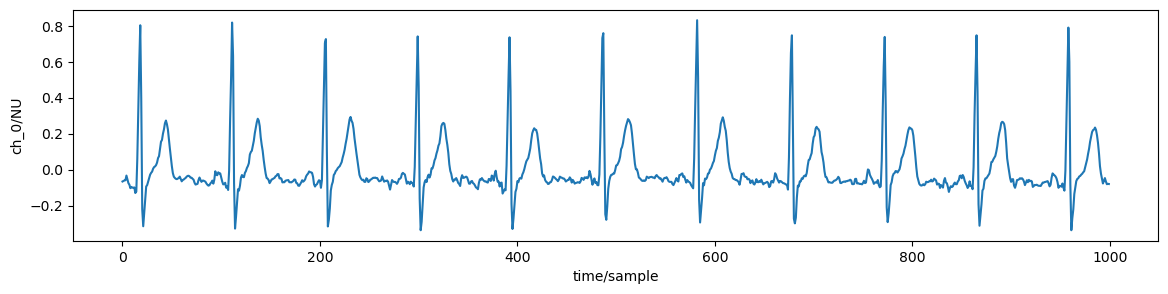

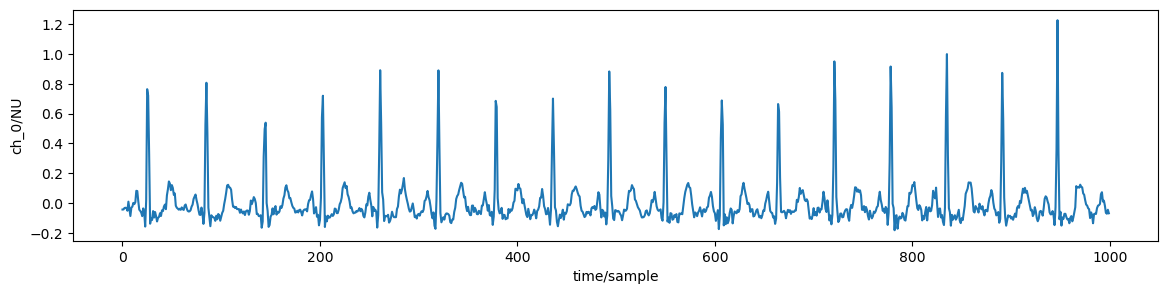

2000
2000
2000
1500
1500
(9000, 1000, 12) (9000, 5)
2000
2000
2000
1500
1500
(9000, 1000, 12) (9000, 5)


In [8]:
X_train, y_train = del_multi_class(X_train, y_train)
X_test, y_test = del_multi_class(X_test, y_test)
X_train, y_train = aug(X_train, y_train)
X_train, y_train = elimination_imbalance(X_train, y_train)
count_of_class(X_train, y_train)
print(X_train.shape, y_train.shape)
X_train, y_train = elimination_imbalance(X_train, y_train)
count_of_class(X_train, y_train)
print(X_train.shape, y_train.shape)
X_train_ra = rolling_average(X_train)
X_test_ra = rolling_average(X_test)
X_train_ft = fourier_transform(X_train)
X_test_ft = fourier_transform(X_test)
X_train_ft_st, X_test_ft_st = standard_scaler(X_train_ft, X_test_ft)
X_train_ra_st, X_test_ra_st = standard_scaler(X_train_ra, X_test_ra)
X_train_st, X_test_st = standard_scaler(X_train, X_test)
del X_train
del X_test

In [9]:
os.chdir("/kaggle/working/")
num_classes = y_train.shape[1]
model_lstm = keras.Sequential()
model_lstm.add(layers.LSTM(input_shape=(1000, 12), units=256,
                return_sequences=True,
                stateful=False, unroll=False
))
model_lstm.add(layers.LeakyReLU())
model_lstm.add(layers.LSTM(units=256,
                return_sequences=False,
                stateful=False, unroll=False
))
model_lstm.add(layers.LeakyReLU())
model_lstm.add(layers.Dense(units=num_classes, activation='softmax'))
print(model_lstm.summary())

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model_lstm.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model_lstm.fit(X_train_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model_lstm.save('lstm_superdiag_1')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 256)         275456    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 802,053
Trainable params: 802,053
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
254/254 [========================

52/52 [==============================] - 3s 46ms/step - loss: 0.9333 - accuracy: 0.6891
score:  [0.9332729578018188, 0.6890909075737]
52/52 [==============================] - 3s 43ms/step
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       184
           1       0.27      0.64      0.39        56
           2       0.60      0.64      0.62       256
           3       0.86      0.69      0.76       912
           4       0.54      0.79      0.64       242

    accuracy                           0.69      1650
   macro avg       0.60      0.68      0.62      1650
weighted avg       0.74      0.69      0.70      1650



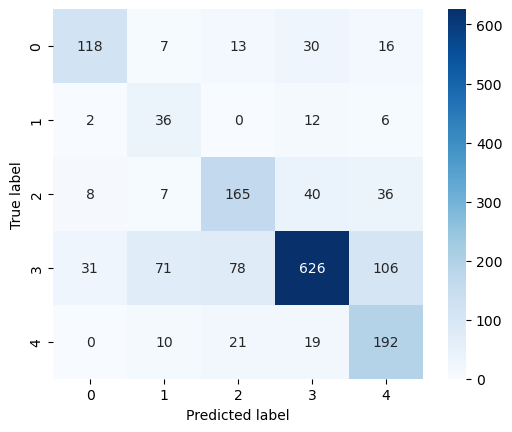

In [10]:
print('score: ', model_lstm.evaluate(X_test_st, y_test))
y_pred = model_lstm.predict(X_test_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))

In [11]:
# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

history = model_lstm.fit(X_train_ft_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model_lstm.save('lstm_superdiag_2')

Epoch 1/100
254/254 [==============================] - 34s 132ms/step - loss: 0.8893 - accuracy: 0.6715 - val_loss: 0.8111 - val_accuracy: 0.6856
Epoch 2/100
254/254 [==============================] - 33s 130ms/step - loss: 0.6804 - accuracy: 0.7485 - val_loss: 0.7900 - val_accuracy: 0.7044
Epoch 3/100
254/254 [==============================] - 33s 129ms/step - loss: 0.6011 - accuracy: 0.7815 - val_loss: 0.7889 - val_accuracy: 0.7122
Epoch 4/100
254/254 [==============================] - 33s 131ms/step - loss: 0.5828 - accuracy: 0.7873 - val_loss: 0.7536 - val_accuracy: 0.7411
Epoch 5/100
254/254 [==============================] - 33s 130ms/step - loss: 0.5198 - accuracy: 0.8047 - val_loss: 0.7805 - val_accuracy: 0.7156
Epoch 6/100
254/254 [==============================] - 33s 129ms/step - loss: 0.4924 - accuracy: 0.8204 - val_loss: 0.7829 - val_accuracy: 0.7244
Epoch 7/100
254/254 [==============================] - 33s 130ms/step - loss: 0.4531 - accuracy: 0.8374 - val_loss: 0.8001 -

52/52 [==============================] - 2s 46ms/step - loss: 0.9116 - accuracy: 0.6648
score:  [0.9115703701972961, 0.6648485064506531]
52/52 [==============================] - 2s 43ms/step
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       184
           1       0.28      0.45      0.34        56
           2       0.50      0.41      0.45       256
           3       0.84      0.72      0.78       912
           4       0.52      0.78      0.62       242

    accuracy                           0.66      1650
   macro avg       0.55      0.60      0.56      1650
weighted avg       0.69      0.66      0.67      1650



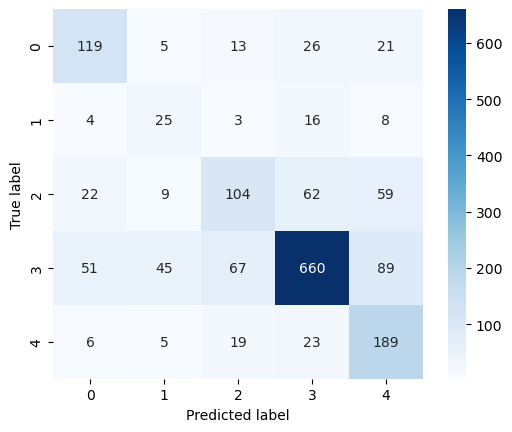

In [12]:
print('score: ', model_lstm.evaluate(X_test_ft_st, y_test))
y_pred = model_lstm.predict(X_test_ft_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))

In [13]:
# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)


history = model_lstm.fit(X_train_ra_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model_lstm.save('lstm_superdiag_3')

Epoch 1/100
254/254 [==============================] - 36s 135ms/step - loss: 0.4901 - accuracy: 0.8201 - val_loss: 0.6750 - val_accuracy: 0.7467
Epoch 2/100
254/254 [==============================] - 33s 130ms/step - loss: 0.4250 - accuracy: 0.8488 - val_loss: 0.7339 - val_accuracy: 0.7422
Epoch 3/100
254/254 [==============================] - 33s 128ms/step - loss: 0.3833 - accuracy: 0.8632 - val_loss: 0.7012 - val_accuracy: 0.7600
Epoch 4/100
254/254 [==============================] - 33s 129ms/step - loss: 0.3478 - accuracy: 0.8740 - val_loss: 0.7425 - val_accuracy: 0.7622
Epoch 5/100
254/254 [==============================] - 33s 130ms/step - loss: 0.3560 - accuracy: 0.8715 - val_loss: 0.7022 - val_accuracy: 0.7622
Epoch 6/100
254/254 [==============================] - 33s 129ms/step - loss: 0.3131 - accuracy: 0.8875 - val_loss: 0.8175 - val_accuracy: 0.7456
Epoch 7/100
254/254 [==============================] - 33s 129ms/step - loss: 0.3321 - accuracy: 0.8832 - val_loss: 0.7434 -

52/52 [==============================] - 3s 46ms/step - loss: 0.8651 - accuracy: 0.6982
score:  [0.865091860294342, 0.6981818079948425]
52/52 [==============================] - 3s 42ms/step
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       184
           1       0.33      0.50      0.40        56
           2       0.53      0.64      0.58       256
           3       0.86      0.72      0.78       912
           4       0.54      0.76      0.63       242

    accuracy                           0.70      1650
   macro avg       0.61      0.65      0.62      1650
weighted avg       0.74      0.70      0.71      1650



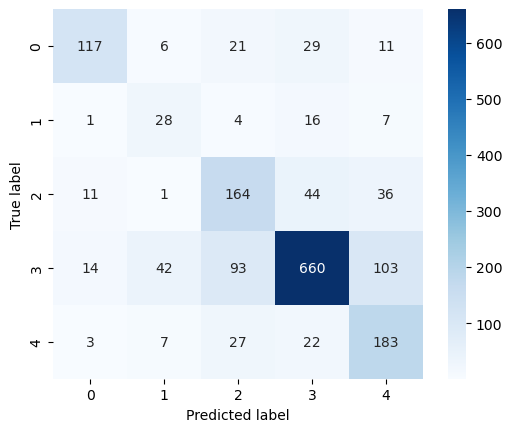

In [14]:
print('score: ', model_lstm.evaluate(X_test_ra_st, y_test))
y_pred = model_lstm.predict(X_test_ra_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))

In [15]:
model_lstm_bidir = keras.Sequential()
model_lstm_bidir.add(layers.Bidirectional(layers.LSTM(input_shape=(1000, 12), units=256,
                      return_sequences=True,
                      stateful=False, unroll=False
                      )))
model_lstm_bidir.add(layers.LeakyReLU())
model_lstm_bidir.add(layers.Bidirectional(layers.LSTM(units=256,
                      return_sequences=False,
                      stateful=False, unroll=False
                      )))
model_lstm_bidir.add(layers.LeakyReLU())
model_lstm_bidir.add(layers.Dense(units=num_classes, activation='softmax'))

model_lstm_bidir.build(input_shape = (None, 1000, 12)) # `input_shape` is the shape of the input data
print(model_lstm_bidir.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1000, 512)        550912    
 l)                                                              
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1000, 512)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 2,128,389
Trainable params: 2,128,389
No

In [16]:
# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm_bidir/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model_lstm_bidir.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model_lstm_bidir.fit(X_train_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model_lstm_bidir.save('lstm_bidir_superdiag_1')

Epoch 1/100
254/254 [==============================] - 82s 298ms/step - loss: 1.5529 - accuracy: 0.2896 - val_loss: 1.5258 - val_accuracy: 0.3156
Epoch 2/100
254/254 [==============================] - 74s 291ms/step - loss: 1.4692 - accuracy: 0.3614 - val_loss: 1.4531 - val_accuracy: 0.3344
Epoch 3/100
254/254 [==============================] - 77s 301ms/step - loss: 1.3502 - accuracy: 0.4254 - val_loss: 1.2394 - val_accuracy: 0.4600
Epoch 4/100
254/254 [==============================] - 77s 302ms/step - loss: 1.0663 - accuracy: 0.5957 - val_loss: 1.0666 - val_accuracy: 0.6100
Epoch 5/100
254/254 [==============================] - 77s 302ms/step - loss: 0.9315 - accuracy: 0.6664 - val_loss: 0.8778 - val_accuracy: 0.6856
Epoch 6/100
254/254 [==============================] - 77s 302ms/step - loss: 0.8384 - accuracy: 0.6967 - val_loss: 0.8774 - val_accuracy: 0.6944
Epoch 7/100
254/254 [==============================] - 77s 303ms/step - loss: 0.7821 - accuracy: 0.7185 - val_loss: 0.7973 -

52/52 [==============================] - 7s 101ms/step - loss: 0.9430 - accuracy: 0.6739
score:  [0.9430034756660461, 0.6739394068717957]
52/52 [==============================] - 6s 98ms/step
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       184
           1       0.25      0.61      0.36        56
           2       0.57      0.65      0.61       256
           3       0.89      0.65      0.75       912
           4       0.54      0.74      0.62       242

    accuracy                           0.67      1650
   macro avg       0.57      0.68      0.60      1650
weighted avg       0.74      0.67      0.69      1650



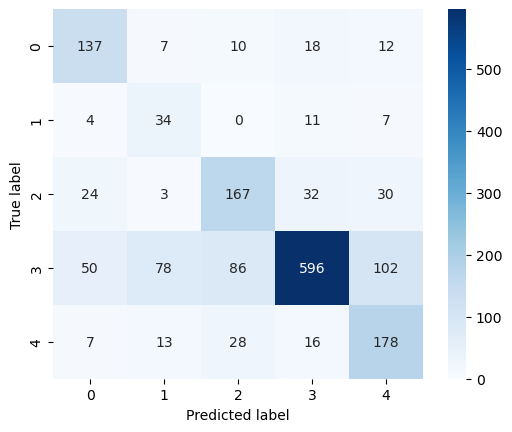

In [17]:
print('score: ', model_lstm_bidir.evaluate(X_test_st, y_test))
y_pred = model_lstm_bidir.predict(X_test_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))

In [18]:
# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm_bidir/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model_lstm_bidir.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model_lstm_bidir.fit(X_train_ft_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model_lstm_bidir.save('lstm_bidir_superdiag_2')

Epoch 1/100
254/254 [==============================] - 86s 311ms/step - loss: 0.8267 - accuracy: 0.6957 - val_loss: 0.9199 - val_accuracy: 0.6522
Epoch 2/100
254/254 [==============================] - 77s 305ms/step - loss: 0.6750 - accuracy: 0.7507 - val_loss: 0.8686 - val_accuracy: 0.6767
Epoch 3/100
254/254 [==============================] - 75s 295ms/step - loss: 0.6043 - accuracy: 0.7793 - val_loss: 0.8202 - val_accuracy: 0.7133
Epoch 4/100
254/254 [==============================] - 75s 294ms/step - loss: 0.5692 - accuracy: 0.7905 - val_loss: 0.7640 - val_accuracy: 0.7056
Epoch 5/100
254/254 [==============================] - 77s 304ms/step - loss: 0.5231 - accuracy: 0.8088 - val_loss: 0.8049 - val_accuracy: 0.7033
Epoch 6/100
254/254 [==============================] - 75s 296ms/step - loss: 0.4719 - accuracy: 0.8272 - val_loss: 0.8449 - val_accuracy: 0.7156
Epoch 7/100
254/254 [==============================] - 75s 295ms/step - loss: 0.4276 - accuracy: 0.8398 - val_loss: 0.7993 -

52/52 [==============================] - 7s 100ms/step - loss: 1.0437 - accuracy: 0.6364
score:  [1.0436822175979614, 0.6363636255264282]
52/52 [==============================] - 6s 97ms/step
              precision    recall  f1-score   support

           0       0.74      0.60      0.66       184
           1       0.19      0.32      0.24        56
           2       0.45      0.48      0.46       256
           3       0.84      0.68      0.75       912
           4       0.46      0.76      0.57       242

    accuracy                           0.64      1650
   macro avg       0.54      0.57      0.54      1650
weighted avg       0.69      0.64      0.65      1650



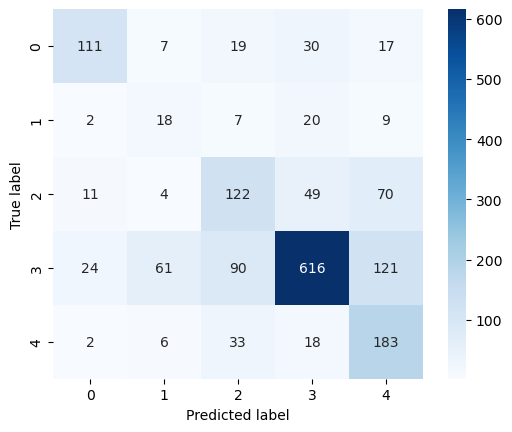

In [19]:
print('score: ', model_lstm_bidir.evaluate(X_test_ft_st, y_test))
y_pred = model_lstm_bidir.predict(X_test_ft_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))

In [20]:
# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_lstm_bidir/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model_lstm_bidir.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model_lstm_bidir.fit(X_train_ra_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model_lstm_bidir.save('lstm_bidir_superdiag_3')

Epoch 1/100
254/254 [==============================] - 85s 301ms/step - loss: 0.5215 - accuracy: 0.8146 - val_loss: 0.7184 - val_accuracy: 0.7622
Epoch 2/100
254/254 [==============================] - 75s 295ms/step - loss: 0.4487 - accuracy: 0.8398 - val_loss: 0.7128 - val_accuracy: 0.7356
Epoch 3/100
254/254 [==============================] - 77s 302ms/step - loss: 0.4037 - accuracy: 0.8600 - val_loss: 0.7301 - val_accuracy: 0.7556
Epoch 4/100
254/254 [==============================] - 77s 303ms/step - loss: 0.4142 - accuracy: 0.8521 - val_loss: 0.7709 - val_accuracy: 0.7456
Epoch 5/100
254/254 [==============================] - 75s 294ms/step - loss: 0.3779 - accuracy: 0.8659 - val_loss: 0.7807 - val_accuracy: 0.7356
Epoch 6/100
254/254 [==============================] - 77s 302ms/step - loss: 0.3375 - accuracy: 0.8794 - val_loss: 0.7827 - val_accuracy: 0.7578
Epoch 7/100
254/254 [==============================] - 77s 302ms/step - loss: 0.3184 - accuracy: 0.8884 - val_loss: 0.7884 -

52/52 [==============================] - 6s 98ms/step - loss: 0.9558 - accuracy: 0.6806
score:  [0.9558484554290771, 0.6806060671806335]
52/52 [==============================] - 6s 93ms/step
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       184
           1       0.26      0.59      0.36        56
           2       0.53      0.63      0.58       256
           3       0.85      0.71      0.78       912
           4       0.56      0.65      0.60       242

    accuracy                           0.68      1650
   macro avg       0.58      0.65      0.60      1650
weighted avg       0.72      0.68      0.69      1650



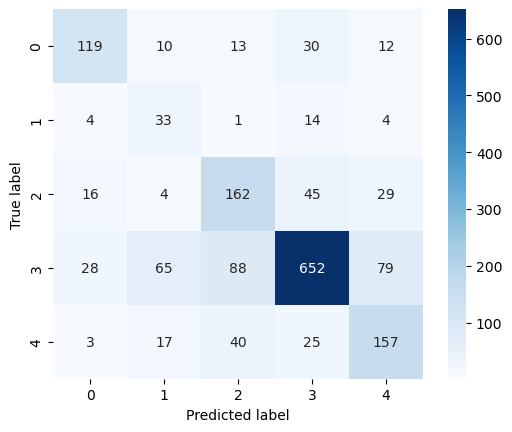

In [21]:
print('score: ', model_lstm_bidir.evaluate(X_test_ra_st, y_test))
y_pred = model_lstm_bidir.predict(X_test_ra_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))